# This notebook reads the full sky angular maps of LIM computed with full_sky_maps.py and cross correlate them with yuuki's maps

In [140]:
import sys
sys.path.append('/home/jlbernal/preLIMinary/')
sys.path.append('/home/jlbernal/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from SkyLine import make_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
import pickle
import healpy as hp
from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


LC_path='/home/jlbernal/LightCone_Fullsky_UM/'

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#949e94']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5



# Read maps

In [2]:
tsz = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/mdpl2_ltszNG_bahamas80_rot_sum_4_176_bnd_unb_1.0e+12_1.0e+18_v103021_lmax24000_nside8192_interp1.0_method1_1_lensed_map.fits')
cib = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/mdpl2_len_mag_cibmap_planck_545.fits')

hi1 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/HI_2dmap_0.4_0.6.fits')
hi2 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/HI_2dmap_0.6_0.8.fits')
hi3 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/HI_2dmap_0.8_1.0.fits')
hi4 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/HI_2dmap_1.0_1.2.fits')
hi5 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/HI_2dmap_1.2_1.4.fits')

lya1 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/Lya_2dmap_2.2_2.4.fits')
lya2 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/Lya_2dmap_2.4_2.6.fits')
lya3 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/Lya_2dmap_2.6_2.8.fits')
lya4 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/Lya_2dmap_2.8_3.0.fits')
lya5 = hp.fitsfunc.read_map('/home/jlbernal/lim_LC_prods/Lya_2dmap_3.0_3.2.fits')




In [3]:
lmax = 2500

cl_tsz_tsz = hp.anafast(tsz,lmax=lmax)
cl_tsz_hi1 = hp.anafast(tsz,hi1,lmax=lmax)
cl_tsz_hi2 = hp.anafast(tsz,hi2,lmax=lmax)
cl_tsz_hi3 = hp.anafast(tsz,hi3,lmax=lmax)
cl_tsz_hi4 = hp.anafast(tsz,hi4,lmax=lmax)
cl_tsz_hi5 = hp.anafast(tsz,hi5,lmax=lmax)
cl_tsz_hitot = hp.anafast(tsz,hi1+hi2+hi3+hi4+hi5,lmax=lmax)
cl_hi1_hi1 = hp.anafast(hi1,lmax=lmax)
cl_hi2_hi2 = hp.anafast(hi2,lmax=lmax)
cl_hi3_hi3 = hp.anafast(hi3,lmax=lmax)
cl_hi4_hi4 = hp.anafast(hi4,lmax=lmax)
cl_hi5_hi5 = hp.anafast(hi5,lmax=lmax)
cl_hitot_hitot = hp.anafast(hi1+hi2+hi3+hi4+hi5,lmax=lmax)






In [4]:
lmax = 2500

cl_cib_cib = hp.anafast(cib,lmax=lmax)
cl_cib_lya1 = hp.anafast(cib,lya1,lmax=lmax)
cl_cib_lya2 = hp.anafast(cib,lya2,lmax=lmax)
cl_cib_lya3 = hp.anafast(cib,lya3,lmax=lmax)
cl_cib_lya4 = hp.anafast(cib,lya4,lmax=lmax)
cl_cib_lya5 = hp.anafast(cib,lya5,lmax=lmax)
cl_cib_lyatot = hp.anafast(cib,lya1+lya2+lya3+lya4+lya5,lmax=lmax)
cl_lya1_lya1 = hp.anafast(lya1,lmax=lmax)
cl_lya2_lya2 = hp.anafast(lya2,lmax=lmax)
cl_lya3_lya3 = hp.anafast(lya3,lmax=lmax)
cl_lya4_lya4 = hp.anafast(lya4,lmax=lmax)
cl_lya5_lya5 = hp.anafast(lya5,lmax=lmax)
cl_lyatot_lyatot = hp.anafast(lya1+lya2+lya3+lya4+lya5,lmax=lmax)


In [5]:
ell = np.arange(len(cl_cib_cib))

In [97]:
def bin_cl(ell,cl,delta_ell):
    
    delta_ell_array = np.arange(ell[0],ell[-1],delta_ell)
    delta_ell_array = np.concatenate((delta_ell_array,np.array([ell[-1]])))
    delta_ell_mid = 0.5*(delta_ell_array[1:]+delta_ell_array[:-1])
        
    cl_bin = np.zeros(len(delta_ell_mid))
    for il in range(len(delta_ell_array)-1):
        cl_bin[il] = np.mean(cl[delta_ell_array[il]:delta_ell_array[il+1]])
        
    return delta_ell_mid,cl_bin

In [131]:
bin_size = 30

In [149]:
bin_ell, bin_cl_tsz_tsz = bin_cl(ell[50:],cl_tsz_tsz[50:],bin_size)
bin_ell, bin_cl_tsz_hi1 = bin_cl(ell[50:],cl_tsz_hi1[50:],bin_size)
bin_ell, bin_cl_tsz_hi2 = bin_cl(ell[50:],cl_tsz_hi2[50:],bin_size)
bin_ell, bin_cl_tsz_hi3 = bin_cl(ell[50:],cl_tsz_hi3[50:],bin_size)
bin_ell, bin_cl_tsz_hi4 = bin_cl(ell[50:],cl_tsz_hi4[50:],bin_size)
bin_ell, bin_cl_tsz_hi5 = bin_cl(ell[50:],cl_tsz_hi5[50:],bin_size)
bin_ell, bin_cl_tsz_hitot = bin_cl(ell[50:],cl_tsz_hitot[50:],bin_size)

bin_ell, bin_cl_hi1_hi1 = bin_cl(ell[50:],cl_hi1_hi1[50:],bin_size)
bin_ell, bin_cl_hi2_hi2 = bin_cl(ell[50:],cl_hi2_hi2[50:],bin_size)
bin_ell, bin_cl_hi3_hi3 = bin_cl(ell[50:],cl_hi3_hi3[50:],bin_size)
bin_ell, bin_cl_hi4_hi4 = bin_cl(ell[50:],cl_hi4_hi4[50:],bin_size)
bin_ell, bin_cl_hi5_hi5 = bin_cl(ell[50:],cl_hi5_hi5[50:],bin_size)
bin_ell, bin_cl_hitot_hitot = bin_cl(ell[50:],cl_hitot_hitot[50:],bin_size)



/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [150]:
bin_ell, bin_cl_cib_cib = bin_cl(ell[50:],cl_cib_cib[50:],bin_size)
bin_ell, bin_cl_cib_lya1 = bin_cl(ell[50:],cl_cib_lya1[50:],bin_size)
bin_ell, bin_cl_cib_lya2 = bin_cl(ell[50:],cl_cib_lya2[50:],bin_size)
bin_ell, bin_cl_cib_lya3 = bin_cl(ell[50:],cl_cib_lya3[50:],bin_size)
bin_ell, bin_cl_cib_lya4 = bin_cl(ell[50:],cl_cib_lya4[50:],bin_size)
bin_ell, bin_cl_cib_lya5 = bin_cl(ell[50:],cl_cib_lya5[50:],bin_size)
bin_ell, bin_cl_cib_lyatot = bin_cl(ell[50:],cl_cib_lyatot[50:],bin_size)

bin_ell, bin_cl_lya1_lya1 = bin_cl(ell[50:],cl_lya1_lya1[50:],bin_size)
bin_ell, bin_cl_lya2_lya2 = bin_cl(ell[50:],cl_lya2_lya2[50:],bin_size)
bin_ell, bin_cl_lya3_lya3 = bin_cl(ell[50:],cl_lya3_lya3[50:],bin_size)
bin_ell, bin_cl_lya4_lya4 = bin_cl(ell[50:],cl_lya4_lya4[50:],bin_size)
bin_ell, bin_cl_lya5_lya5 = bin_cl(ell[50:],cl_lya5_lya5[50:],bin_size)
bin_ell, bin_cl_lyatot_lyatot = bin_cl(ell[50:],cl_lyatot_lyatot[50:],bin_size)



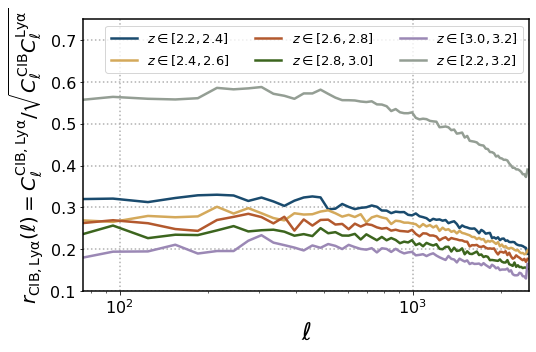

In [152]:

plt.semilogx(bin_ell,bin_cl_cib_lya1/(bin_cl_lya1_lya1*bin_cl_cib_cib)**0.5,label=r'$z\in[2.2,2.4]$')
plt.semilogx(bin_ell,bin_cl_cib_lya2/(bin_cl_lya2_lya2*bin_cl_cib_cib)**0.5,label=r'$z\in[2.4,2.6]$')
plt.semilogx(bin_ell,bin_cl_cib_lya3/(bin_cl_lya3_lya3*bin_cl_cib_cib)**0.5,label=r'$z\in[2.6,2.8]$')
plt.semilogx(bin_ell,bin_cl_cib_lya4/(bin_cl_lya4_lya4*bin_cl_cib_cib)**0.5,label=r'$z\in[2.8,3.0]$')
plt.semilogx(bin_ell,bin_cl_cib_lya5/(bin_cl_lya5_lya5*bin_cl_cib_cib)**0.5,label=r'$z\in[3.0,3.2]$')
plt.semilogx(bin_ell,bin_cl_cib_lyatot/(bin_cl_lyatot_lyatot*bin_cl_cib_cib)**0.5,label=r'$z\in[2.2,3.2]$')
plt.legend(ncol=3,fontsize=13)

plt.xlabel(r'$\ell$',fontsize=24)
plt.ylabel(r'$r_{\rm CIB,Ly\alpha}(\ell)=C_\ell^{\rm CIB,Ly\alpha}/\sqrt{C_\ell^{\rm CIB}C_\ell^{\rm Ly\alpha}}$',fontsize=20)

plt.xlim(75,2500)
plt.ylim(0.1,0.75)

plt.grid(linestyle='dotted', linewidth=1.5)

plt.savefig('../../lim_LC_prods/Cl_Lya_x_cib.pdf', bbox_inches='tight', dpi=300)



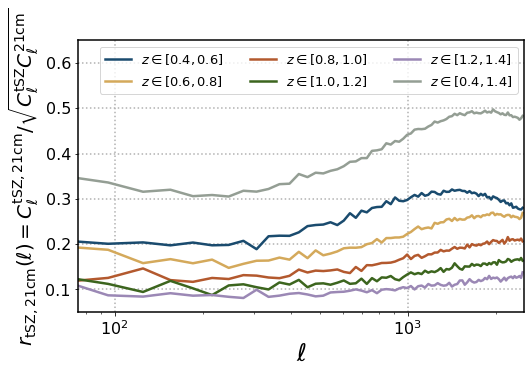

In [155]:
plt.semilogx(bin_ell,bin_cl_tsz_hi1/(bin_cl_hi1_hi1*bin_cl_tsz_tsz)**0.5,label=r'$z\in[0.4,0.6]$')
plt.semilogx(bin_ell,bin_cl_tsz_hi2/(bin_cl_hi2_hi2*bin_cl_tsz_tsz)**0.5,label=r'$z\in[0.6,0.8]$')
plt.semilogx(bin_ell,bin_cl_tsz_hi3/(bin_cl_hi3_hi3*bin_cl_tsz_tsz)**0.5,label=r'$z\in[0.8,1.0]$')
plt.semilogx(bin_ell,bin_cl_tsz_hi4/(bin_cl_hi4_hi4*bin_cl_tsz_tsz)**0.5,label=r'$z\in[1.0,1.2]$')
plt.semilogx(bin_ell,bin_cl_tsz_hi5/(bin_cl_hi5_hi5*bin_cl_tsz_tsz)**0.5,label=r'$z\in[1.2,1.4]$')
plt.semilogx(bin_ell,bin_cl_tsz_hitot/(bin_cl_hitot_hitot*bin_cl_tsz_tsz)**0.5,label=r'$z\in[0.4,1.4]$')
plt.legend(ncol=3,fontsize=13)

plt.xlabel(r'$\ell$',fontsize=24)
plt.ylabel(r'$r_{\rm tSZ,21cm}(\ell)=C_\ell^{\rm tSZ,21cm}/\sqrt{C_\ell^{\rm tSZ}C_\ell^{\rm 21cm}}$',fontsize=20)

plt.xlim(75,2500)
plt.ylim(0.05,0.65)

plt.grid(linestyle='dotted', linewidth=1.5)
plt.savefig('../../lim_LC_prods/Cl_21cm_x_tsz.pdf', bbox_inches='tight', dpi=300)


In [147]:
(((2*u.arcmin)**2).to(u.sr)/16/np.log(2))**-0.5

<Quantity 5724.22385202 1 / sr(1/2)>

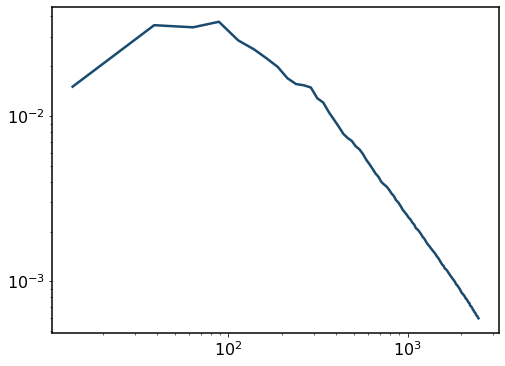

In [72]:
plt.loglog(bin_ell,bin_cl_lyatot_lyatot)
#plt.loglog(bin_ell,bin_cl_cib_lyatot)
#plt.loglog(bin_ell,bin_cl_cib_cib)


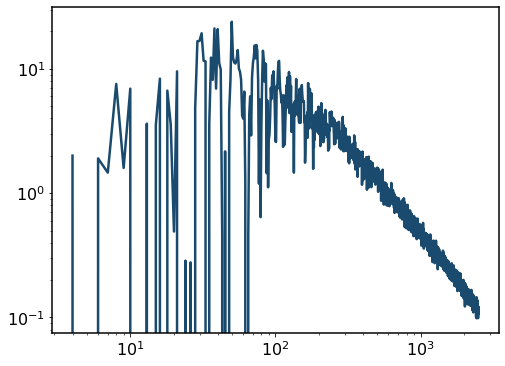

In [69]:
plt.loglog(ell[4:],cl_cib_lya1[4:])


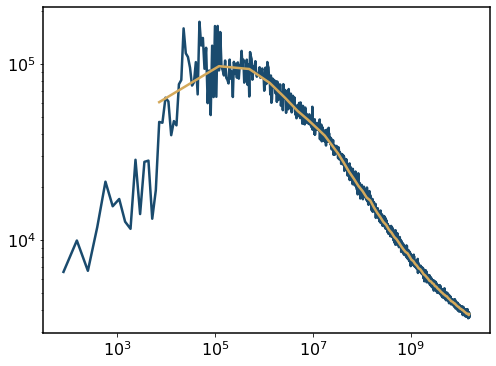

In [28]:
plt.loglog(factor[4:]*ell[4:],cl_cib_cib[4:])
plt.loglog(bin_factor*bin_ell,bin_cl_cib_cib)

In [47]:
cl_cib_cib

array([2.00709931e+12, 1.80197725e+03, 3.69053486e+04, ...,
       3.77206068e+03, 3.84603186e+03, 3.75250711e+03])